[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hamidrg/Textual_Emotion_detect/blob/master/Transformers/BERT.ipynb)

## 1. Install Required Libraries

In [ ]:
!pip install transformers datasets scikit-learn spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 120.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 2. Import Libraries

In [ ]:
import pandas as pd
import numpy as np

## 3. Load and Prepare Dataset

In [ ]:
import kagglehub
path = kagglehub.dataset_download("akhilvibhakar/isear-raw")

df = pd.read_csv(path + "/ISEAR-raw-utf8.csv")
df.head()

,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,...,SELF,RELA,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE
0,11001,1,1,1,1,33,1,2,6,1,...,3,3,2,0,joy,4,3,110011,"During the period of falling in love, each tim...",1
1,11001,1,1,1,1,33,1,2,6,1,...,2,2,0,0,fear,3,2,110012,When I was involved in a traffic accident.,1
2,11001,1,1,1,1,33,1,2,6,1,...,2,1,0,0,anger,1,3,110013,When I was driving home after several days of...,1
3,11001,1,1,1,1,33,1,2,6,1,...,1,1,0,2,sadness,4,4,110014,When I lost the person who meant the most to me.,1
4,11001,1,1,1,1,33,1,2,6,1,...,0,2,0,0,disgust,4,4,110015,The time I knocked a deer down - the sight of ...,1


In [ ]:
import spacy
import re

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def spacy_preprocess(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.like_num:
            tokens.append(token.lemma_.lower())
    return " ".join(tokens)



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preprocess
df['clean_text'] = df['SIT'].apply(spacy_preprocess)

# Encode labels
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['Field1'])

label_names = le.classes_

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_text'], df['label_id'], test_size=0.2, random_state=42
)


In [ ]:
df.head()

,ID,CITY,COUN,SUBJ,SEX,AGE,RELI,PRAC,FOCC,MOCC,...,VERBAL,NEUTRO,Field1,Field3,Field2,MYKEY,SIT,STATE,clean_text,label_id
0,11001,1,1,1,1,33,1,2,6,1,...,2,0,joy,4,3,110011,"During the period of falling in love, each tim...",1,period fall love time meet á \n especially mee...,4
1,11001,1,1,1,1,33,1,2,6,1,...,0,0,fear,3,2,110012,When I was involved in a traffic accident.,1,involve traffic accident,2
2,11001,1,1,1,1,33,1,2,6,1,...,0,0,anger,1,3,110013,When I was driving home after several days of...,1,drive home day hard work á \n motorist ahead...,0
3,11001,1,1,1,1,33,1,2,6,1,...,0,2,sadness,4,4,110014,When I lost the person who meant the most to me.,1,lose person mean,5
4,11001,1,1,1,1,33,1,2,6,1,...,0,0,disgust,4,4,110015,The time I knocked a deer down - the sight of ...,1,time knock deer sight animal á \n injury helpl...,1


In [ ]:
df['Field1'].value_counts()

,count
Field1,
anger,1096
disgust,1096
sadness,1096
shame,1096
fear,1095
joy,1094
guilt,1093


## 4. Tokenizer & Dataset Preparation

In [ ]:
from transformers import BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=400)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=400)

class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, train_labels.tolist())
test_dataset = EmotionDataset(test_encodings, test_labels.tolist())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 5. BERT Model Definition

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_names))

def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# TrainingArguments()
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=4e-5,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bluedarkcode (bluedarkcode-shahid-rajai-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.091866,0.610821,0.626684,0.610821,0.610081
2,1.317300,1.037435,0.641460,0.643415,0.641460,0.637322
3,0.770600,1.143538,0.644068,0.646388,0.644068,0.644209


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.091866,0.610821,0.626684,0.610821,0.610081
2,1.317300,1.037435,0.641460,0.643415,0.641460,0.637322
3,0.770600,1.143538,0.644068,0.646388,0.644068,0.644209
4,0.441600,1.220010,0.639505,0.641416,0.639505,0.640131


TrainOutput(global_step=1536, training_loss=0.8319548660268387, metrics={'train_runtime': 506.9867, 'train_samples_per_second': 48.38, 'train_steps_per_second': 3.03, 'total_flos': 1046234078114400.0, 'train_loss': 0.8319548660268387, 'epoch': 4.0})

## 8. Saving Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save
model.save_pretrained("/content/drive/MyDrive/bert_emotion_model_spacy")
tokenizer.save_pretrained("/content/drive/MyDrive/bert_emotion_model_spacy")

# # Load
# from transformers import BertForSequenceClassification, BertTokenizer

# model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/bert_emotion_model_spacy")
# tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/bert_emotion_model_spacy")
# model.eval()

('/content/drive/MyDrive/bert_emotion_model_spacy/tokenizer_config.json',
 '/content/drive/MyDrive/bert_emotion_model_spacy/special_tokens_map.json',
 '/content/drive/MyDrive/bert_emotion_model_spacy/vocab.txt',
 '/content/drive/MyDrive/bert_emotion_model_spacy/added_tokens.json')

## 10. Evaluation

Classification Report:

              precision    recall  f1-score   support

       anger       0.57      0.56      0.56       223
     disgust       0.67      0.66      0.67       224
        fear       0.81      0.73      0.77       207
       guilt       0.49      0.55      0.52       205
         joy       0.71      0.80      0.75       217
     sadness       0.73      0.71      0.72       232
       shame       0.55      0.50      0.53       226

    accuracy                           0.64      1534
   macro avg       0.65      0.64      0.64      1534
weighted avg       0.65      0.64      0.64      1534



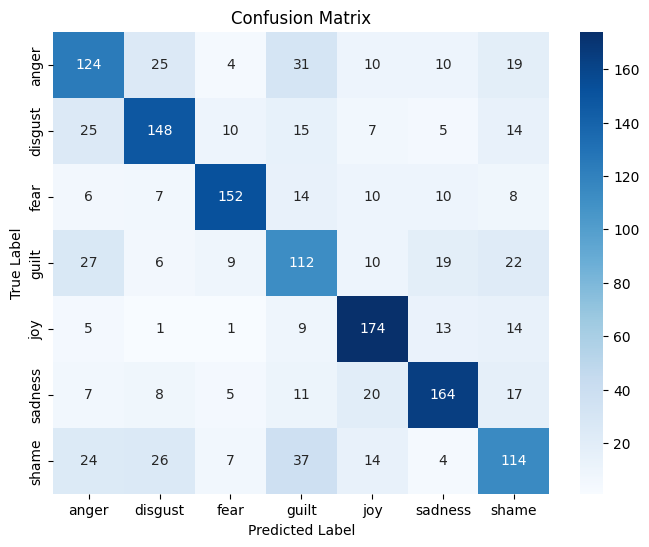

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch


model.eval()
all_preds = []
all_labels = []

for batch in torch.utils.data.DataLoader(test_dataset, batch_size=32):
    input_ids = batch['input_ids'].to(model.device)
    attention_mask = batch['attention_mask'].to(model.device)
    labels = batch['labels'].to(model.device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())


target_names = label_names

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_emotion(text):
    clean_text = spacy_preprocess(text)
    inputs = tokenizer(clean_text, return_tensors="pt", truncation=True, padding=True, max_length=400)


    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted = torch.argmax(logits, dim=1).item()

    return label_names[predicted]

# Example
print(predict_emotion("I'm so excited to watch this movie!"))
print(predict_emotion("I smiled through the pain like everything was okay."))
print(predict_emotion("I don't even care anymore, it's just... whatever."))
print(predict_emotion("They never listened, and now it's too late."))
print(predict_emotion("The silence after the argument was louder than words."))
print(predict_emotion("I feel like everyone is watching me and judging."))

joy
joy
sadness
guilt
shame
shame
